##Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive/Turing 2023

/content/gdrive/.shortcut-targets-by-id/1TKg9_9uC3HI5dNoOFlhh1s7MxiDPA0GF/Turing 2023


In [ ]:
%cd Extracted Shipping Reports

/content/gdrive/.shortcut-targets-by-id/1TKg9_9uC3HI5dNoOFlhh1s7MxiDPA0GF/Turing 2023/Extracted Shipping Reports


In [ ]:
%cd shipping_csv_cleaned/PE0001106

/content/gdrive/.shortcut-targets-by-id/1TKg9_9uC3HI5dNoOFlhh1s7MxiDPA0GF/Turing 2023/Extracted Shipping Reports/shipping_csv_cleaned/PE0001106


## Process

In [ ]:
import pandas as pd
import os

In [ ]:
list_files = os.listdir()

docs_list = pd.DataFrame({
    'name': list_files,
    'shipping report': [None] * len(list_files)
})

print(docs_list)

          name shipping report
0      .config            None
1       gdrive            None
2  sample_data            None


In [ ]:
df = pd.DataFrame({})
for index, row in docs_list.iterrows():
  df_new = pd.read_csv(row['name'])
  if not df_new.empty:
    df = pd.concat([df,df_new])


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df.set_index('Date', inplace=True)
df_monthly = df.resample('M').sum()
top_ports = df.groupby('Port')['Tonnage'].sum().nlargest(5).index
df_top_ports = df[df['Port'].isin(top_ports)]
df_top_ports_monthly = df_top_ports.groupby(['Port', pd.Grouper(freq='M')])['Tonnage'].sum().unstack(level=0)


<ipython-input-10-bff8836a5f19>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').sum()


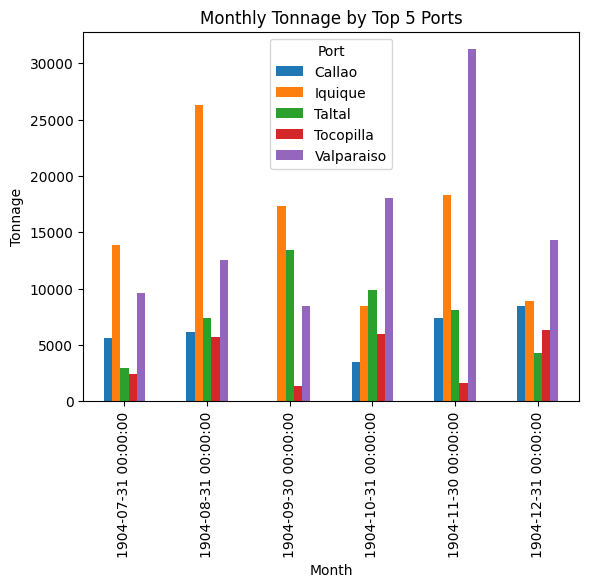

In [ ]:
df_top_ports_monthly.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Tonnage')
plt.title('Monthly Tonnage by Top 5 Ports')
plt.legend(title='Port', loc='best')
plt.show()

## Consignees analysis

### Cleaning text

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')  # Load English model

In [ ]:
df['Consignees_lower'] = df['Consignees'].str.replace('[^a-zA-Z\s]', '').str.replace('\d+', '').str.lower()
df['Consignees_lower'] = df['Consignees_lower'].str.replace("   ","")
df['Consignees_lower'] = df['Consignees_lower'].str.replace("  ","")
df['consignees_lemmas'] = df['Consignees_lower'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop]))


<ipython-input-13-971d238a2ac3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Consignees_lower'] = df['Consignees'].str.replace('[^a-zA-Z\s]', '').str.replace('\d+', '').str.lower()


In [ ]:
## Removing empty data
df_not_empty = df.loc[df['Consignees']!='empty']

In [ ]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Vectorize the names using TF-IDF
vectorizer = TfidfVectorizer(min_df=1, analyzer='char', ngram_range=(1,2))
tf_idf_matrix = vectorizer.fit_transform(df_not_empty['Consignees_lower'])

# Step 2: Compute the similarity matrix
similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix)

# Convert the similarity matrix to a distance matrix and replace any negative values with zero
dist_matrix = 1 - similarity_matrix
dist_matrix[dist_matrix < 0] = 0

# Convert the distance matrix to a condensed distance matrix
condensed_matrix = dist_matrix[np.triu_indices(dist_matrix.shape[0], k=1)]

# Step 3: Perform hierarchical clustering
Z = linkage(condensed_matrix, method='average')

# Set your desired distance threshold
distance_threshold = 0.5

# Assign each name to a cluster based on the distance threshold
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Add the cluster assignments to the dataframe
df_not_empty['cluster'] = clusters

# Display the dataframe sorted by cluster
df_not_empty.sort_values(by='cluster')


<ipython-input-15-054bfbe9a7cb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_empty['cluster'] = clusters


,Port,Name,Tonnage,Consignees,Cargo,Consignees_lower,consignees_lemmas,cluster
Date,,,,,,,,
1904-08-21,Antofagasta,Craigerne,1774.0,Gibbs & Co,Coal,gibbsco,gibbsco,1
1904-10-22,Taltal,Hilston,1897.0,Gibbs y Cia,Coal,gibbs y cia,gibbs y cia,1
1904-08-29,Tocopilla,Wega,1945.0,Gibbs & Co,Coal,gibbsco,gibbsco,1
1904-08-29,Antofagasta,James Kerr,2228.0,Gibbs & Co,Coal,gibbsco,gibbsco,1
1904-08-25,Carrizal,Falstaff,1419.0,Gibbs & Co,Coal,gibbsco,gibbsco,1
...,...,...,...,...,...,...,...,...
1904-11-06,Taltal,Glenclova,2246.0,F. C. de Taltal,Coal,f c de taltal,f c de taltal,25
1904-12-01,Antofagasta,Alala S. S,2041.0,Antofagasta R'way,Coal,antofagasta rway,antofagasta rway,26
1904-09-26,Antofagata,Ashanti S.S,2186.0,F. C. de Antofagasta,Coal,f c de antofagasta,f c de antofagasta,26


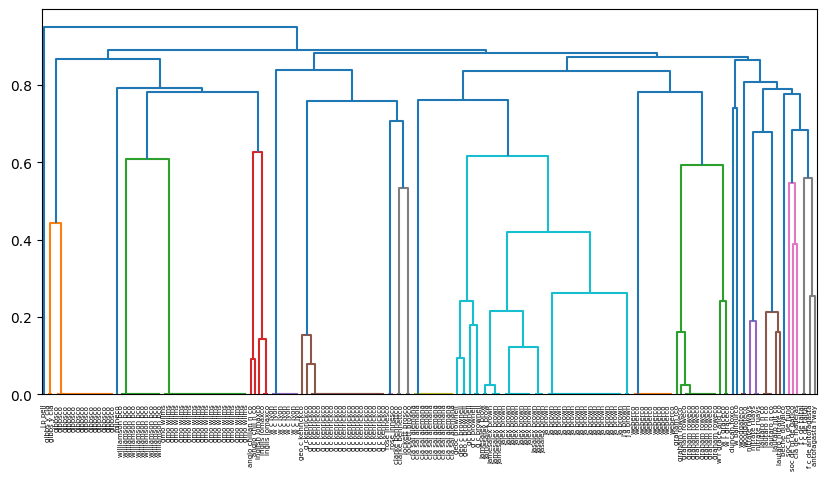

In [ ]:
# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=df_not_empty['Consignees_lower'].tolist(), leaf_rotation=90)
plt.show()

In [ ]:
# Group by the cluster and get the first name in each cluster
representative_names = df_not_empty.groupby('cluster')['Consignees'].first()

# Now, representative_names is a series where the index is the cluster number and the value is the representative name
# You can convert it to a dictionary for easier lookup
representative_names_dict = representative_names.to_dict()

# Add a new column to the dataframe with the representative name for each cluster
df_not_empty['representative_name'] = df_not_empty['cluster'].map(representative_names_dict)


<ipython-input-17-ba04cb85207f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_empty['representative_name'] = df_not_empty['cluster'].map(representative_names_dict)


In [ ]:
df_not_empty.to_csv('combined.csv')

In [ ]:
top_consignees = df_not_empty.groupby('representative_name')['Tonnage'].sum().nlargest(5).index
df_top_consignees = df_not_empty[df_not_empty['representative_name'].isin(top_consignees)]
df_top_consignees_monthly = df_top_consignees.groupby(['representative_name', pd.Grouper(freq='M')])['Tonnage'].sum().unstack(level=0)


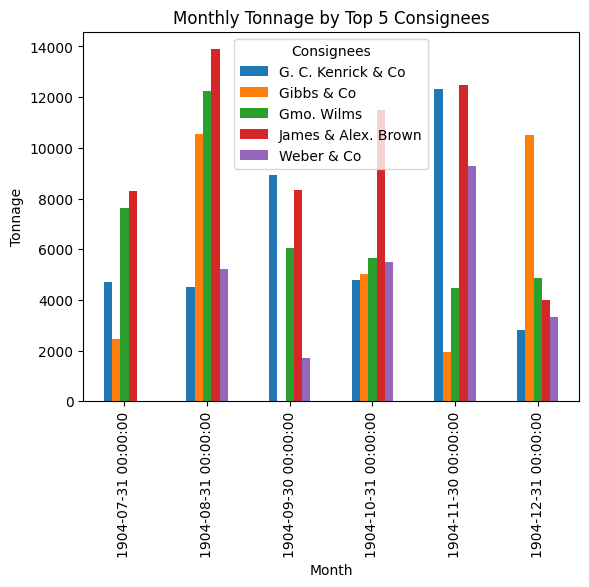

In [ ]:
df_top_consignees_monthly.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Tonnage')
plt.title('Monthly Tonnage by Top 5 Consignees')
plt.legend(title='Consignees', loc='best')
plt.show()

## Names check

In [ ]:
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
df['Name_lower'] = df['Name'].str.replace('[^a-zA-Z\s]', '').str.replace('\d+', '').str.lower()

<ipython-input-34-5e82bdffde45>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Name'] = df['Name'].str.replace('[^a-zA-Z\s]', '').str.replace('\d+', '').str.lower()


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
df['lemmas'] = df['Name_lower'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop]))
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['lemmas'])
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(vectors)
df['cluster'] = clusters


In [ ]:
for cluster in df['cluster'].unique():
    names = df[df['cluster'] == cluster]['Name_lower'].tolist()
    text = '\n'.join(names)
    doc = nlp(text)
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
df

,Port,Name,Tonnage,Consignees,Cargo,lemmas,cluster
Date,,,,,,,
1904-07-24,Valparaiso,lita,1643.0,G. C. Kenrick & Co,Coal,lita,1
1904-07-25,Valparaiso,carl,1205.0,"Inglis, Lomax & Co",Coal,carl,1
1904-07-26,Valparaiso,allerton,1938.0,James & Alex. Brown,Coal,allerton,1
1904-07-27,Iquique,kate thomas,1597.0,empty,Coal,kate thomas,1
1904-07-28,Iquique,michele bianchi,1657.0,empty,Ballast,michele bianchi,1
...,...,...,...,...,...,...,...
1904-12-11,Callao,eudora,1861.0,empty,General,eudora,1
1904-12-24,Peña Blanca,irby,1480.0,Graham Rowe & Co,Coal,irby,1
1904-12-23,Valparaiso,macdiarmid,1568.0,"Williamson, B. & Co",Cement,macdiarmid,1
